# Topic: Malaria Detection Via Cell Images

Dataset can be found [here](https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria).




# A. Image Analysis & Preprocessing

## 1. Importing the required libraries and modules

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random
import cv2
import os
import shutil

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import pickle
from tensorflow.keras.applications import densenet
from glob import glob
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, InputLayer, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

%matplotlib inline

## 2. Loading the images
Printing random 5 images from each categories - Parasite & Uninfected

### Configuring the path of the categories in the dataset

In [ ]:
parasitized_dir = '/content/cell_images/Parasitized'
uninfected_dir = '/content/cell_images/Uninfected'
dataset_dir = '/content/cell_images'

In [ ]:
def load_random_imgs_from_folder(folder):
  plt.figure(figsize=(20,20))
  for i in range(5):
    file = random.choice(os.listdir(folder))
    image_path = os.path.join(folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.xlabel(f'Image Shape: {img.shape}')
    plt.imshow(img)

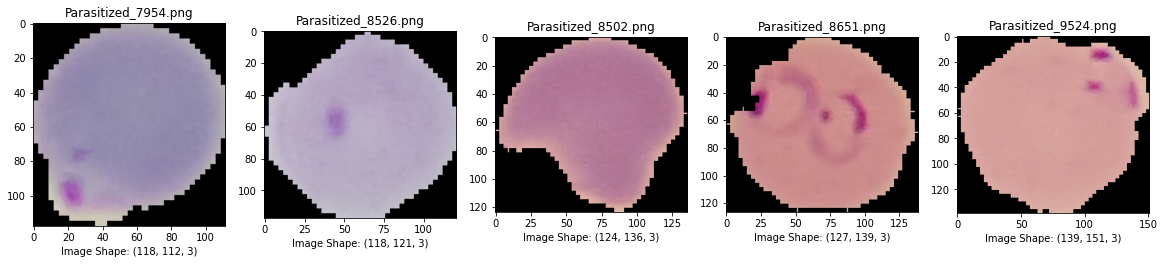

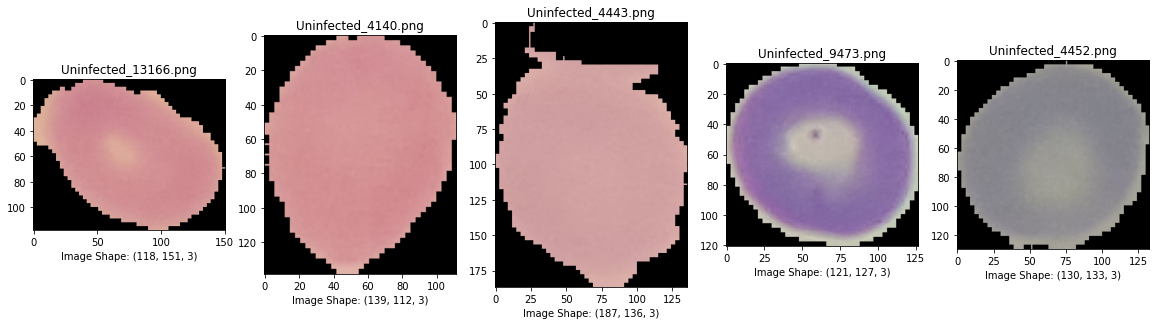

In [ ]:
load_random_imgs_from_folder(parasitized_dir)
print('\n\n')
load_random_imgs_from_folder(uninfected_dir)

## 3. Renaming the datasets

In [ ]:
def rename_imgs(category, path):
  # print(os.getcwd())
  os.chdir(path)
  print(os.getcwd())
  for index, filename in enumerate(os.listdir(".")):
    # print(filename, index)
    os.rename(filename, f'{category}_{index+1}.png')
    # print(filename)
  print(f'Renaming {category} Category Successful')

In [ ]:
rename_imgs('Parasitized', parasitized_dir)
rename_imgs('Uninfected', uninfected_dir)

/content/cell_images/Parasitized
Renaming Parasitized Category Successful
/content/cell_images/Uninfected
Renaming Uninfected Category Successful


## 5. Create database and splitting to train, test and val

In [ ]:
IMG_SIZE = 64 # downscaled to fit the lowest height and width of the train images
# IMG_SIZE = 224 # usually used size for CNN architecture
# IMG_SIZE = 128

In [ ]:
classes=[]
for i in os.listdir(dataset_dir):
  classes+=[i]

print(classes)

['Uninfected', 'Parasitized']


In [ ]:
def create_dataset(data_dir):
    data = [] 
    for label in classes: 
        path = os.path.join(data_dir, label)
        class_num = classes.index(label)
        for img in os.listdir(path):
            try:
              if img[-3:] != 'txt':
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
dataset = create_dataset(dataset_dir)
np.random.shuffle(dataset)

'NoneType' object is not subscriptable
'NoneType' object is not subscriptable


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


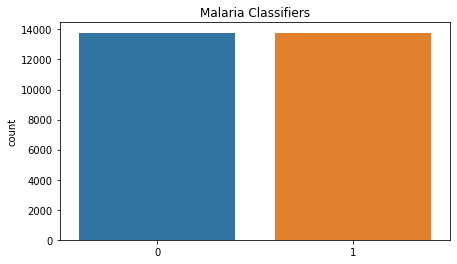

In [ ]:
# plot to check the balance of the classes in the dataset
plt.figure(figsize=(7,4))
sns.countplot(dataset[:,1]);
plt.title('Malaria Classifiers');

In [ ]:
len(dataset)*0.6

16534.8

In [ ]:
train = dataset[:16534]
val = dataset[16534:22046]
test = dataset[22046:]

In [ ]:
train_df = pd.DataFrame(train, columns=['Images', 'Label'])

In [ ]:
train_df.head(5)

,Images,Label
0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1
2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",1
4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


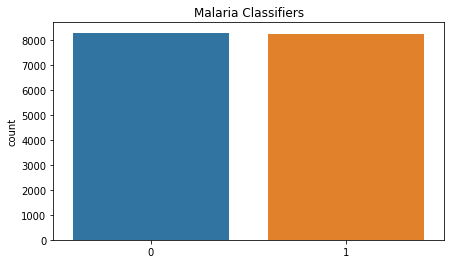

In [ ]:
#  plotting the count of classes in train dataset

plt.figure(figsize=(7,4))
sns.countplot(train[:,1]);
plt.title('Malaria Classifiers');

In [ ]:
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

for feature, label in test:
  x_test.append(feature)
  y_test.append(label)


In [ ]:
y_val = keras.utils.to_categorical(y_val,  dtype ="uint8")
y_test = keras.utils.to_categorical(y_test,  dtype ="uint8")
y_train = keras.utils.to_categorical(y_train,  dtype ="uint8")

In [ ]:
print(y_train[:10])

[[1 0]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]]


## 6. Image Pre-processing

### 6.1. Normalizing the dataset

In [ ]:
type(x_train)

list

In [ ]:
x_train = np.array(x_train) / 255.0
y_train = np.array(y_train)
x_val = np.array(x_val) / 255.0
y_val = np.array(y_val)

In [ ]:
x_test = np.array(x_test) / 255.0
y_test = np.array(y_test)

In [ ]:
type(x_train)

numpy.ndarray

In [ ]:
print(f"Shape of x_train --> {x_train.shape} & y_train --> {y_train.shape}")
print(f"Shape of x_val --> {x_val.shape} & y_val --> {y_val.shape}")
print(f"Shape of x_test --> {x_test.shape} & y_test --> {y_test.shape}")

Shape of x_train --> (16534, 64, 64, 3) & y_train --> (16534, 2)
Shape of x_val --> (5512, 64, 64, 3) & y_val --> (5512, 2)
Shape of x_test --> (5512, 64, 64, 3) & y_test --> (5512, 2)


### 7. Model Implementation using Densenet Transfer Learning

In [ ]:
model_d = densenet.DenseNet121(weights="imagenet", 
                    include_top=False,
                    input_tensor=Input(shape = (64,64,3))
                    )

29097984/29084464 [==============================] - 0s 0us/step


In [ ]:
z = model_d.output
z = GlobalAveragePooling2D()(z)
z = BatchNormalization()(z)
z = Dropout(0.5)(z)
z = Dense(1024,activation='relu')(z) 
z = Dense(512,activation='relu')(z) 
z = BatchNormalization()(z)
z = Dropout(0.5)(z)
preds=Dense(len(folders),activation='softmax')(z)

In [ ]:
densenet_model = Model(inputs=model_d.input,outputs=preds)
densenet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 32, 32, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1/conv[0][0]']             
                                                                                              

In [ ]:
for layer in model_d.layers:
  layer.trainable = False

In [ ]:
densenet_model.compile(loss="categorical_crossentropy", optimizer = "adam",
              metrics = ["accuracy", tf.keras.metrics.Precision(), 
                        tf.keras.metrics.Recall()])

In [ ]:
filepath="/content/models/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
densenet_history = densenet_model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=30,
    validation_data=(x_val, y_val),
    callbacks=callbacks_list
)

Epoch 1/30
259/259 [==============================] - ETA: 0s - loss: 0.3389 - accuracy: 0.8822 - precision: 0.8822 - recall: 0.8822
Epoch 1: accuracy improved from -inf to 0.88224, saving model to /content/models/weights-improvement-01-0.92.hdf5
259/259 [==============================] - 33s 129ms/step - loss: 0.3389 - accuracy: 0.8822 - precision: 0.8822 - recall: 0.8822 - val_loss: 0.2065 - val_accuracy: 0.9227 - val_precision: 0.9227 - val_recall: 0.9227
Epoch 2/30
258/259 [============================>.] - ETA: 0s - loss: 0.2291 - accuracy: 0.9103 - precision: 0.9103 - recall: 0.9103
Epoch 2: accuracy improved from 0.88224 to 0.91037, saving model to /content/models/weights-improvement-02-0.93.hdf5
259/259 [==============================] - 25s 97ms/step - loss: 0.2290 - accuracy: 0.9104 - precision: 0.9104 - recall: 0.9104 - val_loss: 0.1902 - val_accuracy: 0.9267 - val_precision: 0.9267 - val_recall: 0.9267
Epoch 3/30
258/259 [============================>.] - ETA: 0s - loss: 0.

In [ ]:
!cp "/content/models/weights-improvement-30-0.94.hdf5" "/content/drive/MyDrive/Hamoye/LSTMGROUPPROJECT/densenet_new_folder"

In [ ]:
#save the model in .h5 format
densenet_model.save(filepath = '/content/drive/MyDrive/Hamoye/LSTMGROUPPROJECT/densenet_new_folder/densenet.h5', include_optimizer = True)
densenet_model.save(filepath = '/content/drive/MyDrive/Hamoye/LSTMGROUPPROJECT/densenet_new_folder/densenet_tf', save_format = 'tf', include_optimizer = True)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Hamoye/LSTMGROUPPROJECT/densenet_new_folder/densenet_tf/assets


## Plotting the accuracy, loss, precision and recall

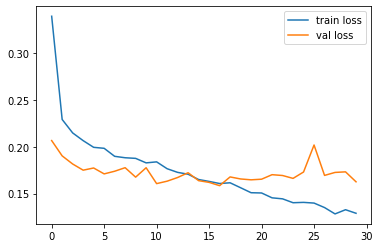

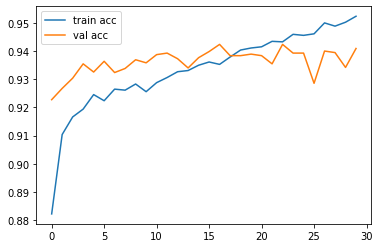

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(densenet_history.history['loss'], label='train loss')
plt.plot(densenet_history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(densenet_history.history['accuracy'], label='train acc')
plt.plot(densenet_history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

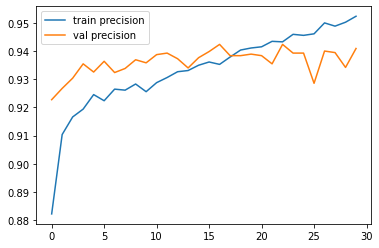

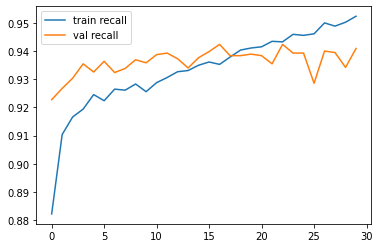

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the Precision
plt.plot(densenet_history.history['precision'], label='train precision')
plt.plot(densenet_history.history['val_precision'], label='val precision')
plt.legend()
plt.show()
plt.savefig('Precision')

# plot the Recall
plt.plot(densenet_history.history['recall'], label='train recall')
plt.plot(densenet_history.history['val_recall'], label='val recall')
plt.legend()
plt.show()
plt.savefig('Recall')

## Saving the History

In [ ]:
hist_df = pd.DataFrame(densenet_history.history)
hist_json_file = '/content/drive/MyDrive/Hamoye/LSTMGROUPPROJECT/densenet_new_folder/history.json'
with open(hist_json_file, mode = 'w') as f:
  hist_df.to_json(f)

## Predict X_Test

In [ ]:
y_pred = densenet_model.predict(x_test)

In [ ]:
print(y_pred)

[[9.9973816e-01 2.6178840e-04]
 [9.7886616e-01 2.1133848e-02]
 [6.2911329e-03 9.9370885e-01]
 ...
 [9.4115347e-01 5.8846515e-02]
 [6.6484390e-08 9.9999988e-01]
 [1.3115531e-04 9.9986887e-01]]


In [ ]:
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
print(y_pred[:20]) #first 10 predictions -- 0 means uninfected 1 means parasitizd

[0 0 1 1 0 1 0 0 1 0 1 1 0 0 0 0 1 0 0 0]


In [ ]:
y_actual = np.argmax(y_test, axis=1)  #True labels for x_test
print(y_actual[:20])

[0 0 1 1 0 1 0 0 1 1 1 1 0 0 0 0 1 1 0 0]


In [ ]:
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_actual.reshape(len(y_actual),1)),1))

[[0 0]
 [0 0]
 [1 1]
 ...
 [0 0]
 [1 1]
 [1 1]]


## Confusion matrix

In [ ]:
matrix = confusion_matrix(y_actual,y_pred)
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[2611  132]
 [ 198 2571]]


In [ ]:
tp, fn, fp, tn = confusion_matrix(y_actual,y_pred).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

Outcome values : 
 2611 132 198 2571


In [ ]:
matrix = classification_report(y_actual,y_pred,labels=[1,0])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           1       0.95      0.93      0.94      2769
           0       0.93      0.95      0.94      2743

    accuracy                           0.94      5512
   macro avg       0.94      0.94      0.94      5512
weighted avg       0.94      0.94      0.94      5512



## Load the model and predict for an image

In [ ]:
model=load_model('/content/drive/MyDrive/Hamoye/LSTMGROUPPROJECT/densenet_new_folder/densenet.h5')

In [ ]:
img=image.load_img('/content/cell_images/Parasitized/Parasitized_100.png',target_size=(64,64))

In [ ]:
x=image.img_to_array(img)
x

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [ ]:
print(x.shape)
x=x/255

(64, 64, 3)


In [ ]:
x=x.reshape(1,64,64,3)
x.shape

(1, 64, 64, 3)

In [ ]:
a=np.argmax(model.predict(x), axis=1)
if(a==0):
    print("Uninfected")
else:
    print("Infected")

Infected
